In [1]:
#### Load in data ####

import os
import cv2
import numpy as np
import pandas as pd
from itertools import product
from tqdm import tqdm
from utils import load_images_by_domain, split_images

# Define paths
img_dir = "../OfficeCaltechDomainAdaptation/images"

# Load images by domain
data_by_domain = load_images_by_domain(
    img_dir=img_dir,
    target_size=(300, 300),  # Standardized size
    method="pad",           # Use padding to maintain aspect ratio
    seed=888                # Seed for reproducibility
)

# Split images: Combine amazon and caltech10 into train/val/test
train_data, val_data, test_data = split_images(
    data_by_domain=data_by_domain,
    train_domains=["amazon", "caltech10"],  # Combine these for training and validation
    test_domains=[],                        # Use part of amazon and caltech10 for testing
    train_split=0.7,                        # 60% for training
    val_split=0.2,                          # 20% for validation
    use_train_for_test=True,                # Use part of train_domains for testing
    test_split=0.1,                         # 20% for testing
    seed=888                                # Seed for reproducibility
)

# Summary of splits
print(f"Train images: {len(train_data['images'])}, Train labels: {len(train_data['labels'])}")
print(f"Validation images: {len(val_data['images'])}, Validation labels: {len(val_data['labels'])}")
print(f"Test images: {len(test_data['images'])}, Test labels: {len(test_data['labels'])}")


Train images: 1456, Train labels: 1456
Validation images: 415, Validation labels: 415
Test images: 210, Test labels: 210


In [8]:
train_orb_df = pd.DataFrame(train_orb)
train_orb_df.columns = [f"vw_{x}" for x in train_orb_df.columns]
train_orb_df['label'] = train_data['labels']
val_orb_df = pd.DataFrame(val_orb)
val_orb_df.columns = [f"vw_{x}" for x in val_orb_df.columns]
val_orb_df['label'] = val_data['labels']
test_orb_df = pd.DataFrame(test_orb)
test_orb_df.columns = [f"vw_{x}" for x in test_orb_df.columns]
test_orb_df['label'] = test_data['labels']

# Save LBP features to CSV in the 'features' subdirectory
train_orb_df.to_csv(os.path.join("features", "train_orb_bovw_features.csv"), index=False)
val_orb_df.to_csv(os.path.join("features", "val_orb_bovw_features.csv"), index=False)
test_orb_df.to_csv(os.path.join("features", "test_orb_bovw_features.csv"), index=False)

print("ORB Bag of Visual Words feature extraction and saving completed successfully!")

ORB Bag of Visual Words feature extraction and saving completed successfully!


In [3]:
# Import LBP function and grayscale conversion from utils
from utils import extract_lbp_features, convert_to_grayscale

# Define LBP parameters
P_values = [8, 16, 24]  # Number of neighbors
R_values = [1, 2, 3]    # Radius
PR_combinations = list(product(P_values, R_values))  # All (P, R) combinations

# Extract LBP features for each split
train_lbp_df = extract_lbp_features(train_data, PR_combinations)
val_lbp_df = extract_lbp_features(val_data, PR_combinations)
test_lbp_df = extract_lbp_features(test_data, PR_combinations)

# Save LBP features to CSV in the 'features' subdirectory
train_lbp_df.to_csv(os.path.join("features", "train_lbp_features.csv"), index=False)
val_lbp_df.to_csv(os.path.join("features", "val_lbp_features.csv"), index=False)
test_lbp_df.to_csv(os.path.join("features", "test_lbp_features.csv"), index=False)

print("LBP feature extraction and saving completed successfully!")

Extracting LBP features from 1247 images...


100%|██████████| 1247/1247 [02:55<00:00,  7.09it/s]


Extracting LBP features from 415 images...


100%|██████████| 415/415 [00:58<00:00,  7.11it/s]


Extracting LBP features from 419 images...


100%|██████████| 419/419 [00:59<00:00,  7.07it/s]


LBP feature extraction and saving completed successfully!


In [2]:
from utils import extract_glcm_features_split

# GLCM parameters
glcm_distances = [1, 2, 3]  # Example distances
glcm_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Example angles in radians

# Extract GLCM features for each split
train_glcm_df = extract_glcm_features_split(train_data, glcm_distances, glcm_angles)
val_glcm_df = extract_glcm_features_split(val_data, glcm_distances, glcm_angles)
test_glcm_df = extract_glcm_features_split(test_data, glcm_distances, glcm_angles)

# Save GLCM features to CSV
import os
os.makedirs("features", exist_ok=True)
train_glcm_df.to_csv(os.path.join("features", "train_glcm_features.csv"), index=False)
val_glcm_df.to_csv(os.path.join("features", "val_glcm_features.csv"), index=False)
test_glcm_df.to_csv(os.path.join("features", "test_glcm_features.csv"), index=False)

print("GLCM feature extraction and saving completed successfully!")


Extracting GLCM features from 1247 images...


100%|██████████| 1247/1247 [00:14<00:00, 88.65it/s]


Extracting GLCM features from 415 images...


100%|██████████| 415/415 [00:04<00:00, 88.80it/s]


Extracting GLCM features from 419 images...


100%|██████████| 419/419 [00:04<00:00, 89.14it/s]


GLCM feature extraction and saving completed successfully!


In [2]:
from utils import extract_gabor_features_split

# Define Gabor parameters
gabor_frequencies = [0.05, 0.1, 0.2, 0.3, 0.5]
gabor_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Extract Gabor features for each split
train_gabor_df = extract_gabor_features_split(train_data, gabor_frequencies, gabor_angles)
val_gabor_df = extract_gabor_features_split(val_data, gabor_frequencies, gabor_angles)
test_gabor_df = extract_gabor_features_split(test_data, gabor_frequencies, gabor_angles)

# Save Gabor features to CSV in the 'features' subdirectory
os.makedirs("features", exist_ok=True)
train_gabor_df.to_csv(os.path.join("features", "train_gabor_features.csv"), index=False)
val_gabor_df.to_csv(os.path.join("features", "val_gabor_features.csv"), index=False)
test_gabor_df.to_csv(os.path.join("features", "test_gabor_features.csv"), index=False)

print("Gabor feature extraction and saving completed successfully!")


Extracting Gabor features from 1247 images...


  0%|          | 0/1247 [00:00<?, ?it/s]c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
100%|██████████| 1247/1247 [43:19<00:00,  2.08s/it] 


Extracting Gabor features from 415 images...


  0%|          | 0/415 [00:00<?, ?it/s]c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
100%|██████████| 415/415 [26:52<00:00,  3.89s/it]


Extracting Gabor features from 419 images...


  0%|          | 0/419 [00:00<?, ?it/s]c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
100%|██████████| 419/419 [20:13<00:00,  2.90s/it]

Gabor feature extraction and saving completed successfully!


In [3]:
from utils import compute_resnet_features

# Dataset splits
dataset_splits = {
    'train': train_data,
    'val': val_data,
    'test': test_data
}
splits_to_process = ['train', 'val', 'test']

# Compute and save ResNet features
resnet_features = compute_resnet_features(
    dataset_splits,
    splits_to_process,
    batch_size=16,
    save_csv=True,
    output_dir="features"
)

print("ResNet feature extraction completed and saved successfully!")


Label to integer mapping: {'backpack': 0, 'bike': 1, 'calculator': 2, 'headphones': 3, 'keyboard': 4, 'laptop': 5, 'monitor': 6, 'mouse': 7, 'mug': 8, 'projector': 9}
Processing train split...
Extracting ResNet features from 1247 images for 'train' split...


Extracting ResNet Features (train split): 100%|██████████| 78/78 [00:02<00:00, 37.15it/s]


ResNet feature extraction completed for 'train' split.
Saved train features to 'features\train_resnet_features.csv'.
Processing val split...
Extracting ResNet features from 415 images for 'val' split...


Extracting ResNet Features (val split): 100%|██████████| 26/26 [00:00<00:00, 41.02it/s]


ResNet feature extraction completed for 'val' split.
Saved val features to 'features\val_resnet_features.csv'.
Processing test split...
Extracting ResNet features from 419 images for 'test' split...


Extracting ResNet Features (test split): 100%|██████████| 27/27 [00:00<00:00, 40.76it/s]


ResNet feature extraction completed for 'test' split.
Saved test features to 'features\test_resnet_features.csv'.
ResNet feature extraction completed and saved successfully!


In [ ]:
from utils import get_orb_features
# define best params determined in ORB_Tuning.ipynb
best_params = {'nfeatures': 575, 'patchSize': 11, 'scaleFactor': 1.38, 'n_clusters': 255}

train_orb, kmeans = get_orb_features(
    imgs=train_data['images'],
    **best_params
)

val_orb, kmeans = get_orb_features(
    imgs=val_data['images'],
    kmeans=kmeans,
    **best_params,
)

test_orb, kmeans = get_orb_features(
    imgs=test_data['images'],
    kmeans=kmeans,
    **best_params
)

train_orb_df = pd.DataFrame(train_orb)
train_orb_df.columns = [f"vw_{x}" for x in train_orb_df.columns]
train_orb_df['label'] = train_data['labels']
val_orb_df = pd.DataFrame(val_orb)
val_orb_df.columns = [f"vw_{x}" for x in val_orb_df.columns]
val_orb_df['label'] = val_data['labels']
test_orb_df = pd.DataFrame(test_orb)
test_orb_df.columns = [f"vw_{x}" for x in test_orb_df.columns]
test_orb_df['label'] = test_data['labels']

# Save LBP features to CSV in the 'features' subdirectory
train_orb_df.to_csv(os.path.join("features", "train_orb_bovw_features.csv"), index=False)
val_orb_df.to_csv(os.path.join("features", "val_orb_bovw_features.csv"), index=False)
test_orb_df.to_csv(os.path.join("features", "test_orb_bovw_features.csv"), index=False)

print("ORB Bag of Visual Words feature extraction and saving completed successfully!")

Getting ORB keypoints...


100%|██████████| 1456/1456 [00:08<00:00, 166.97it/s]


No kmeans was provided, so fitting a new one...
Getting ORB keypoints...


100%|██████████| 415/415 [00:01<00:00, 331.47it/s]


Getting ORB keypoints...


100%|██████████| 210/210 [00:00<00:00, 398.47it/s]


/opt/miniconda3/envs/W281/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


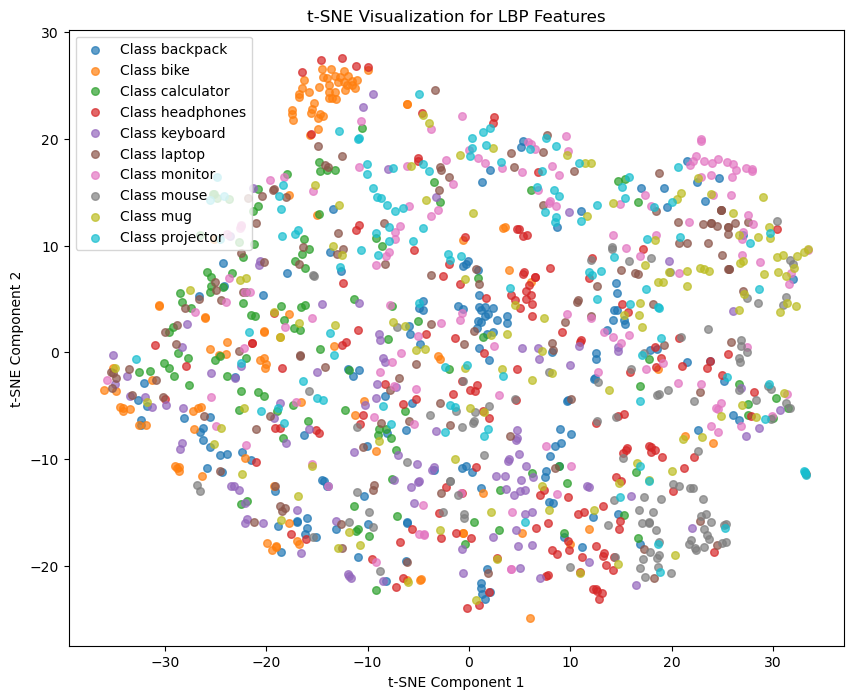

/opt/miniconda3/envs/W281/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


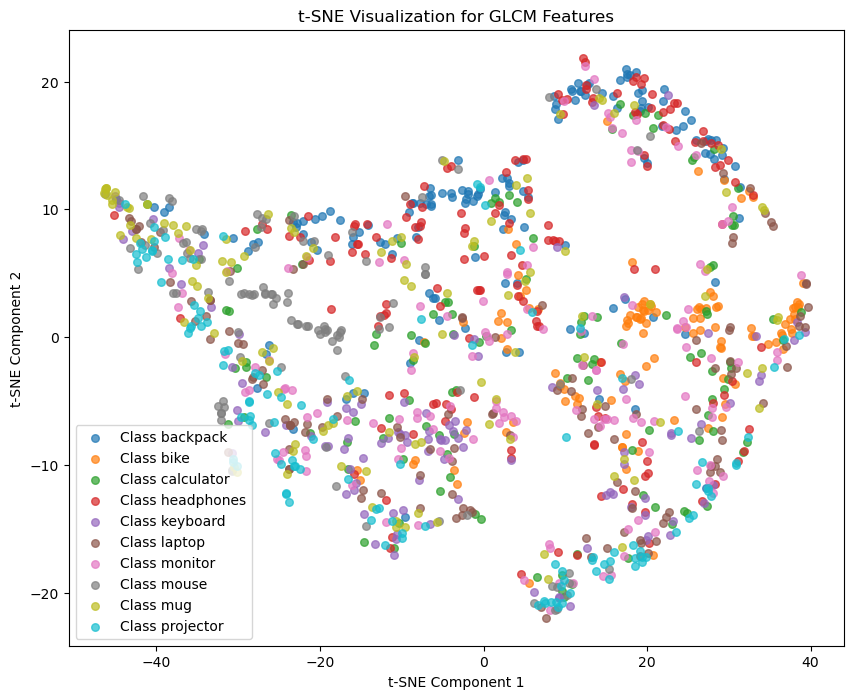

/opt/miniconda3/envs/W281/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


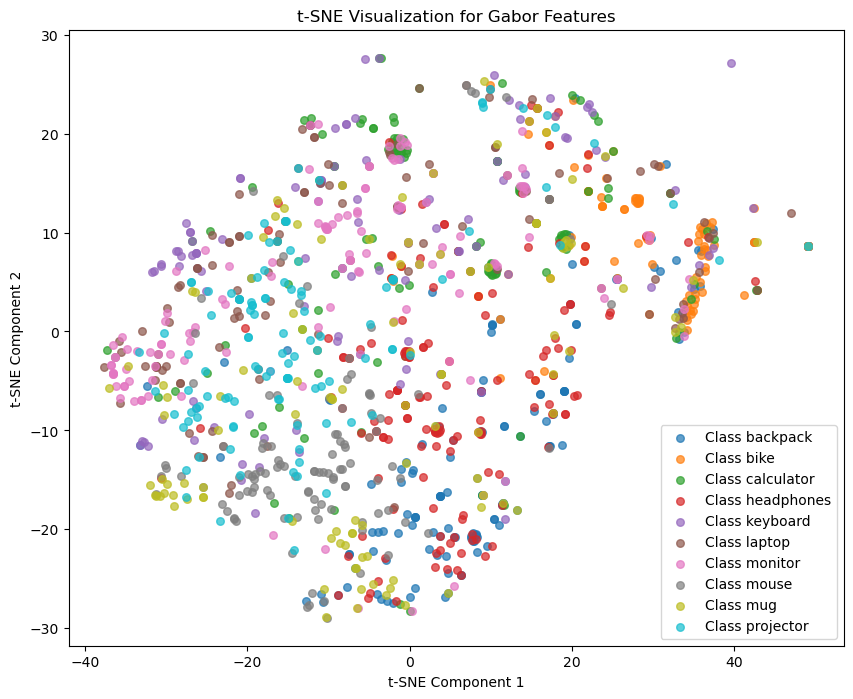

/opt/miniconda3/envs/W281/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


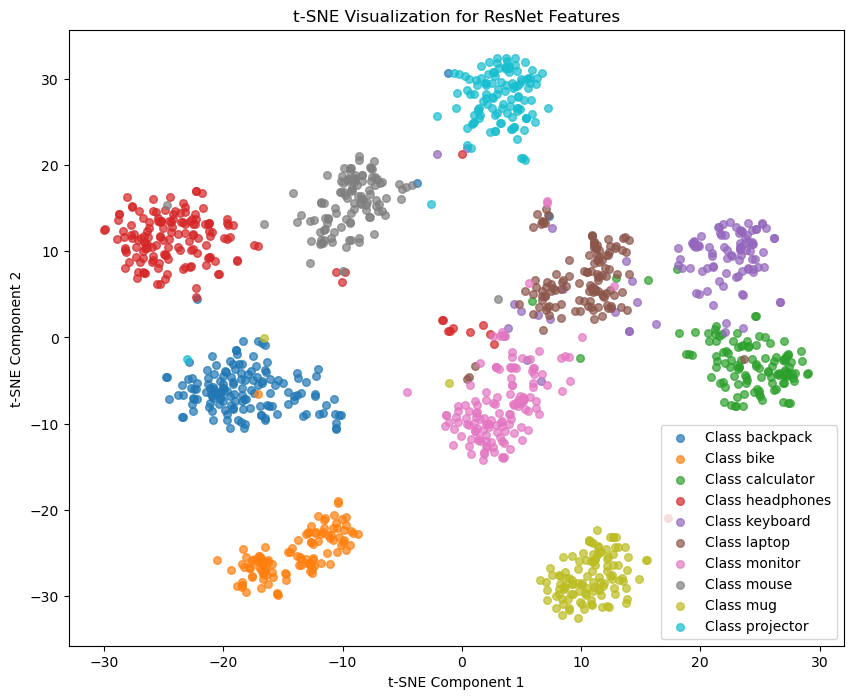

/opt/miniconda3/envs/W281/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


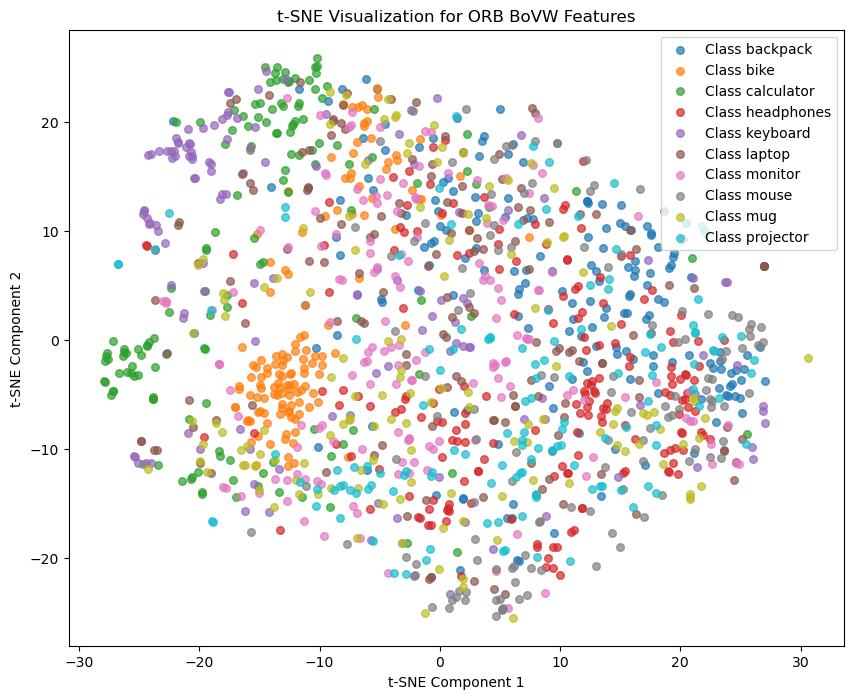

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load CSV files
file_paths = {
    "LBP": r"features/train_lbp_features.csv",
    "GLCM": r"features/train_glcm_features.csv",
    "Gabor": r"features/train_gabor_features.csv",
    "ResNet": r"features/train_resnet_features.csv",
    "ORB BoVW": r"features/train_orb_bovw_features.csv"
}

datasets = {}

# Load datasets from CSV files
for method, path in file_paths.items():
    df = pd.read_csv(path)
    features = df.drop(columns=["label"]).values
    labels = df["label"].values
    # Add to the datasets dictionary
    datasets[method] = (features, labels)

# Function to preprocess features
def preprocess_features(features):
    # Replace infinity and NaN values
    features = np.nan_to_num(features, nan=0.0, posinf=1e6, neginf=-1e6)
    # Clip values to a reasonable range
    features = np.clip(features, -1e6, 1e6)
    return features

# Preprocess features for all datasets
for method in datasets:
    features, labels = datasets[method]
    datasets[method] = (preprocess_features(features), labels)

# Function to apply t-SNE
def apply_tsne(features):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    features_2d = tsne.fit_transform(features)
    return features_2d

# Plot t-SNE results for each method
for method, (features, labels) in datasets.items():
    # Apply t-SNE
    features_2d = apply_tsne(features)
    
    # Plot the results
    plt.figure(figsize=(10, 8))
    for category_id in np.unique(labels):
        idxs = np.where(labels == category_id)
        plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], 
                    label=f"Class {category_id}", alpha=0.7, s=30)
    
    plt.legend()
    plt.title(f"t-SNE Visualization for {method} Features")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()


Analyzing LBP...


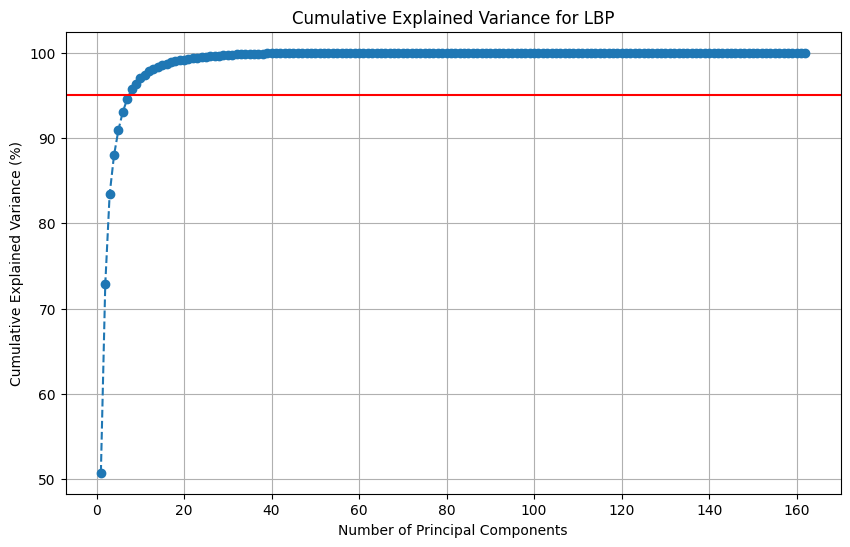

Number of components for 95% explained variance (LBP): 8
Analyzing GLCM...


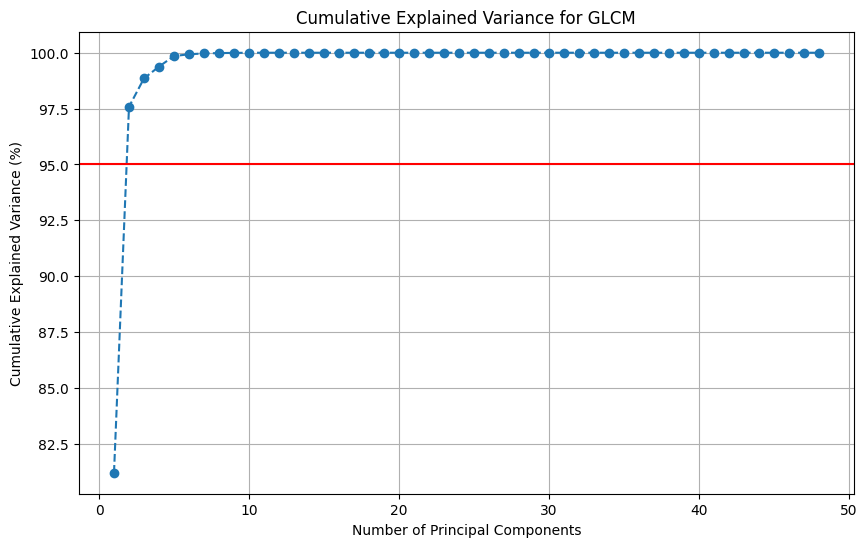

Number of components for 95% explained variance (GLCM): 2
Analyzing Gabor...


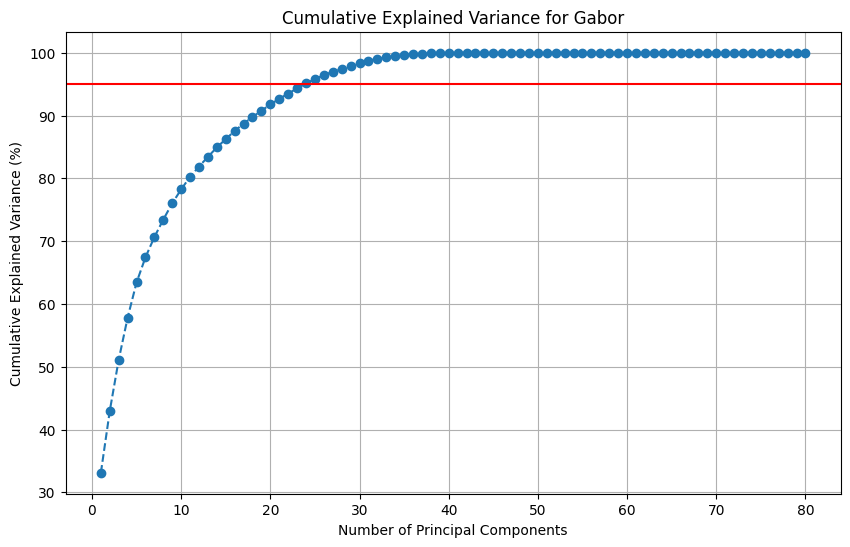

Number of components for 95% explained variance (Gabor): 24
Analyzing ResNet...


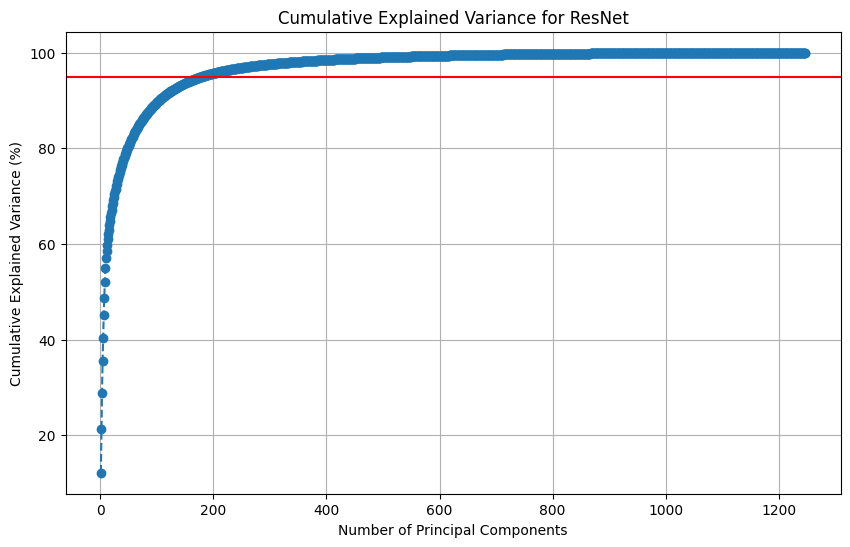

Number of components for 95% explained variance (ResNet): 180


In [5]:
from sklearn.decomposition import PCA  # Import PCA from sklearn

# Function to plot explained variance ratio
def plot_explained_variance(features, method_name):
    pca = PCA()  # PCA with all components
    pca.fit(features)
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_) * 100

    # Plot the cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, len(explained_variance_ratio) + 1),
        explained_variance_ratio,
        marker='o',
        linestyle='--',
    )
    plt.axhline(y=95, color='r', linestyle='-')
    plt.title(f"Cumulative Explained Variance for {method_name}")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance (%)")
    plt.grid()
    plt.show()

    # Find the number of components to reach 95% variance
    n_components_95 = np.argmax(explained_variance_ratio >= 95) + 1
    print(f"Number of components for 95% explained variance ({method_name}): {n_components_95}")
    return n_components_95

# Visualize PCA explained variance for each method
for method, (features, _) in datasets.items():
    print(f"Analyzing {method}...")
    n_components = plot_explained_variance(features, method_name=method)


In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# File paths for features
file_paths = {
    "LBP": {
        "train": r"features/train_lbp_features.csv",
        "val": r"features/val_lbp_features.csv",
        "test": r"features/test_lbp_features.csv",
    },
    "GLCM": {
        "train": r"features/train_glcm_features.csv",
        "val": r"features/val_glcm_features.csv",
        "test": r"features/test_glcm_features.csv",
    },
    "Gabor": {
        "train": r"features/train_gabor_features.csv",
        "val": r"features/val_gabor_features.csv",
        "test": r"features/test_gabor_features.csv",
    },
    "ResNet": {
        "train": r"features/train_resnet_features.csv",
        "val": r"features/val_resnet_features.csv",
        "test": r"features/test_resnet_features.csv",
    },
    "ORB BoVW": {
        "train": r"features/train_orb_bovw_features.csv",
        "val": r"features/val_orb_bovw_features.csv",
        "test": r"features/test_orb_bovw_features.csv",
    }
}

# Step 1: Load features from CSV files
def load_features(file_paths):
    features = []
    labels = None

    for method, paths in file_paths.items():
        df = pd.read_csv(paths["train"])
        features.append(df.drop(columns=["label"]).values)  # Drop label column
        if labels is None:
            labels = df["label"].values  # Use labels from the first feature type
        else:
            assert np.array_equal(labels, df["label"].values), "Labels mismatch between features!"

    return np.hstack(features), labels  # Combine features horizontally and return labels

# Step 2: Clean invalid values in the features
def clean_features(features):
    """
    Cleans the input features by handling invalid values:
    - Replaces NaN with 0
    - Replaces +inf with 1e6 and -inf with -1e6
    - Clips extreme values to the range [-1e6, 1e6]
    """
    features = np.nan_to_num(features, nan=0.0, posinf=1e6, neginf=-1e6)
    features = np.clip(features, -1e6, 1e6)
    return features

# Load and clean features
train_features, train_labels = load_features({k: v for k, v in file_paths.items()})
train_features = clean_features(train_features)

val_features, val_labels = load_features({k: {"train": v["val"]} for k, v in file_paths.items()})
val_features = clean_features(val_features)

test_features, test_labels = load_features({k: {"train": v["test"]} for k, v in file_paths.items()})
test_features = clean_features(test_features)

# Step 3: Normalize the training features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)

# Step 4: Fit PCA on training features
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of variance
train_features_reduced = pca.fit_transform(train_features_normalized)

print(f"Number of components capturing 95% variance: {pca.n_components_}")

# Step 5: Transform validation and test features using the same PCA
val_features_normalized = scaler.transform(val_features)  # Use the same scaler
val_features_reduced = pca.transform(val_features_normalized)

test_features_normalized = scaler.transform(test_features)  # Use the same scaler
test_features_reduced = pca.transform(test_features_normalized)

# Step 6: Train an SVM model
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(train_features_reduced, train_labels)

# Step 7: Validate the model
val_predictions = svm_model.predict(val_features_reduced)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:")
print(classification_report(val_labels, val_predictions))

# Step 8: Test the model
test_predictions = svm_model.predict(test_features_reduced)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:")
print(classification_report(test_labels, test_predictions))


AssertionError: Labels mismatch between features!

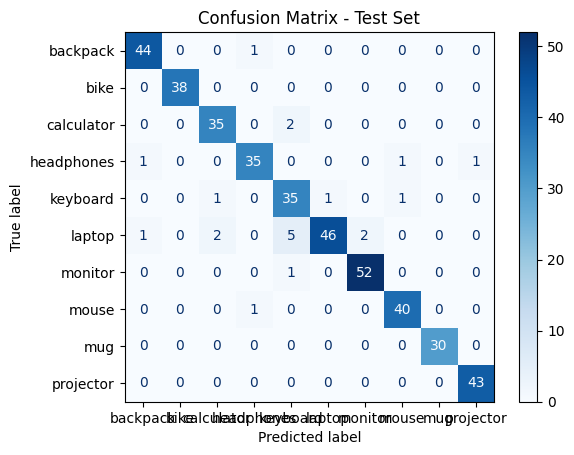

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix for the test set
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(test_labels))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix - Test Set")
plt.show()


In [ ]:
# Extract only test data from the "dslr" domain
_, _, dslr_webcam_test = split_images(
    data_by_domain=data_by_domain,
    train_domains=[],            # No training domains needed
    test_domains=["dslr", "webcam"],       # Use only the "dslr" domain for testing
    train_split=0.0,             # No training data
    val_split=0.0,               # No validation data
    test_split=1.0,              # Use all data for testing
    use_train_for_test=False,    # Do not mix training domains with testing
    seed=888                     # Ensure reproducibility
)

# Print the number of images and labels in the dslr test set
print(f"Dslr Test images: {len(dslr_webcam_test['images'])}, Dslr Test labels: {len(dslr_webcam_test['labels'])}")


Dslr Test images: 157, Dslr Test labels: 157


In [ ]:
from utils import extract_gabor_features_split, extract_glcm_features_split,extract_lbp_features,extract_resnet_features_split

# Extract features from dslr test dataset
dslr_webcam_test_data = dslr_webcam_test["images"]
dslr_webcam_test_labels = dslr_webcam_test["labels"]

# Define LBP Parameters
P_values = [8, 16, 24]  # Number of neighbors
R_values = [1, 2, 3]    # Radius
PR_combinations = list(product(P_values, R_values))

# Wrap dslr test data into a dictionary as required by the function
dslr_webcam_test_split_data = {
    "images": dslr_webcam_test,  # Array of images
    "labels": dslr_webcam_test_labels  # Corresponding labels
}

# Extract LBP features
dslr_webcam_lbp_df = extract_lbp_features(dslr_webcam_test_split_data, PR_combinations)
dslr_webcam_lbp_df["label"] = dslr_webcam_test_labels  # Add labels
dslr_webcam_lbp_df.to_csv(os.path.join("features", "dslr_webcam_test_lbp_features.csv"), index=False)

# Define GLCM Parameters
glcm_distances = [1, 2, 3]  # Example distances
glcm_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Example angles in radians

# Extract GLCM features
dslr_webcam_glcm_df = extract_glcm_features_split(dslr_webcam_test_split_data, glcm_distances, glcm_angles)
dslr_webcam_glcm_df["label"] = dslr_webcam_test_labels  # Add labels
dslr_webcam_glcm_df.to_csv(os.path.join("features", "dslr_webcam_test_glcm_features.csv"), index=False)

# Define Gabor Parameters
gabor_frequencies = [0.05, 0.1, 0.2, 0.3, 0.5]
gabor_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Extract Gabor features
dslr_webcam_gabor_df = extract_gabor_features_split(dslr_webcam_test_split_data, gabor_frequencies, gabor_angles)
dslr_webcam_gabor_df["label"] = dslr_webcam_test_labels  # Add labels
dslr_webcam_gabor_df.to_csv(os.path.join("features", "dslr_webcam_test_gabor_features.csv"), index=False)

# ResNet Extraction
dataset_splits = {
    "test": {"images": dslr_webcam_test_data, "labels": dslr_webcam_test_labels}
}
splits_to_process = ["test"]

# Compute and save ResNet features
resnet_features = compute_resnet_features(
    dataset_splits=dataset_splits,
    splits_to_process=splits_to_process,
    batch_size=16,
    save_csv=True,
    output_dir="features"
)

# define best params determined in ORB_Tuning.ipynb
best_params = {'nfeatures': 575, 'patchSize': 11, 'scaleFactor': 1.38, 'n_clusters': 255}

dslr_webcam_orb, kmeans = get_orb_features(
    imgs=dslr_webcam_test_data,
    **best_params,
    kmeans=kmeans
)

orb_bovw_features_df = pd.DataFrame(dslr_webcam_orb)
orb_bovw_features_df.columns = [f"vw_{x}" for x in orb_bovw_features_df.columns]
orb_bovw_features_df['label'] = dslr_webcam_test_labels

# Save LBP features to CSV in the 'features' subdirectory
orb_bovw_features_df.to_csv(os.path.join("features", "dslr_webcam_test_orb_bovw_features.csv"), index=False)

Extracting LBP features from 157 images...


100%|██████████| 157/157 [00:22<00:00,  7.00it/s]


Extracting GLCM features from 157 images...


100%|██████████| 157/157 [00:01<00:00, 94.20it/s]


Extracting Gabor features from 157 images...


  0%|          | 0/157 [00:00<?, ?it/s]c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
100%|██████████| 157/157 [04:40<00:00,  1.79s/it]


Label to integer mapping: {'backpack': 0, 'bike': 1, 'calculator': 2, 'headphones': 3, 'keyboard': 4, 'laptop': 5, 'monitor': 6, 'mouse': 7, 'mug': 8, 'projector': 9}
Processing test split...
Extracting ResNet features from 157 images for 'test' split...


Extracting ResNet Features (test split): 100%|██████████| 10/10 [00:00<00:00, 20.27it/s]


ResNet feature extraction completed for 'test' split.
Saved test features to 'features\test_resnet_features.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# DSLR & Webcam-specific file paths
dslr_webcam_file_paths = {
    "LBP": {"test": r"features/dslr_webcam_test_lbp_features.csv"},
    "GLCM": {"test": r"features/dslr_webcam_test_glcm_features.csv"},
    "Gabor": {"test": r"features/dslr_webcam_test_gabor_features.csv"},
    "ResNet": {"test": r"features/dslr_webcam_test_resnet_features.csv"},
    "ORB BoVW": {"test": r"features/dslr_webcam_test_orb_bovw_features.csv"}
}

# Function to load DSLR test features
def load_dslr_webcam_test_features(file_paths):
    features = []
    labels = None

    for method, paths in file_paths.items():
        df = pd.read_csv(paths["test"])
        features.append(df.drop(columns=["label"]).values)
        if labels is None:
            labels = df["label"].values
        else:
            assert np.array_equal(labels, df["label"].values), "Labels mismatch between features!"

    return np.hstack(features), labels

# Load and clean DSLR test features
dslr_webcam_test_features, dslr_webcam_test_labels = load_dslr_webcam_test_features(dslr_webcam_file_paths)
dslr_webcam_test_features = clean_features(dslr_webcam_test_features)

# Normalize and transform DSLR test features using training transformations
dslr_webcam_test_features_normalized = scaler.transform(dslr_webcam_test_features)
dslr_webcam_test_features_reduced = pca.transform(dslr_webcam_test_features_normalized)

# Evaluate the model on DSLR test features
dslr_webcam_test_predictions = svm_model.predict(dslr_webcam_test_features_reduced)
dslr_webcam_test_accuracy = accuracy_score(dslr_webcam_test_labels, dslr_webcam_test_predictions)

print(f"DSLR & Webcam Test Accuracy: {dslr_webcam_test_accuracy}")
print("DSLR & Webcam Test Classification Report:")
print(classification_report(dslr_webcam_test_labels, dslr_webcam_test_predictions))

DSLR Test Accuracy: 0.9363057324840764
DSLR Test Classification Report:
              precision    recall  f1-score   support

    backpack       0.71      1.00      0.83        12
        bike       1.00      1.00      1.00        21
  calculator       1.00      0.92      0.96        12
  headphones       1.00      1.00      1.00        13
    keyboard       0.67      1.00      0.80        10
      laptop       1.00      0.83      0.91        24
     monitor       1.00      0.77      0.87        22
       mouse       1.00      1.00      1.00        12
         mug       1.00      1.00      1.00         8
   projector       1.00      1.00      1.00        23

    accuracy                           0.94       157
   macro avg       0.94      0.95      0.94       157
weighted avg       0.96      0.94      0.94       157



DSLR Test Accuracy: 0.9363057324840764
DSLR Test Classification Report:
              precision    recall  f1-score   support

    backpack       0.71      1.00      0.83        12
        bike       1.00      1.00      1.00        21
  calculator       1.00      0.92      0.96        12
  headphones       1.00      1.00      1.00        13
    keyboard       0.67      1.00      0.80        10
      laptop       1.00      0.83      0.91        24
     monitor       1.00      0.77      0.87        22
       mouse       1.00      1.00      1.00        12
         mug       1.00      1.00      1.00         8
   projector       1.00      1.00      1.00        23

    accuracy                           0.94       157
   macro avg       0.94      0.95      0.94       157
weighted avg       0.96      0.94      0.94       157



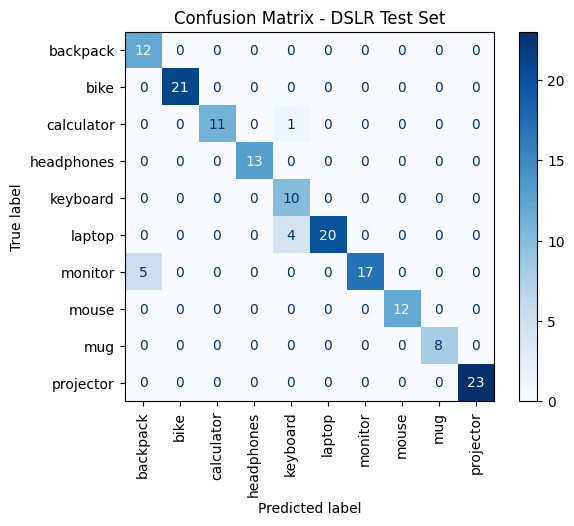

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on DSLR test features
dslr_webcam_test_predictions = svm_model.predict(dslr_webcam_test_features_reduced)
dslr_webcam_test_accuracy = accuracy_score(dslr_webcam_test_labels, dslr_webcam_test_predictions)

# Print classification report and accuracy
print(f"DSLR & Webcam Test Accuracy: {dslr_webcam_test_accuracy}")
print("DSLR & Webcam Test Classification Report:")
print(classification_report(dslr_webcam_test_labels, dslr_webcam_test_predictions))

# Compute confusion matrix
conf_matrix = confusion_matrix(dslr_webcam_test_labels, dslr_webcam_test_predictions)

# Display confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(dslr_webcam_test_labels))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix - DSLR & Webcam Test Set")
plt.show()
